In [1]:
import numpy as np
from mnist import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from PIL import Image
from matplotlib import pyplot as plt
import copy

In [2]:
def shuffle(X, y):
    permutation = np.arange(X.shape[0])
    np.random.shuffle(permutation)
    return X[permutation], y[permutation]

def load_dataset():
    mndata = MNIST('./data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, _ = map(np.array, mndata.load_testing())
    return X_train, labels_train, X_test

In [3]:
X_train, labels_train, _ = load_dataset()
# X_train, labels_train = shuffle(X_train, labels_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, labels_train, test_size=0.33, random_state=42)

X_train[0].reshape(28, 28)

plt.imshow(X_train[2].reshape(28, 28), interpolation='nearest')

img = Image.fromarray(X_train[2].reshape(28, 28))
img.show()

In [4]:
X_train.shape

(40200, 784)

In [5]:
X_test.shape

(19800, 784)

In [6]:
D = 10000 # dimensions in random space
IMG_LEN = 28
NUM_SAMPLES = X_train.shape[0]

In [ ]:
# print("Generating random projection...")
# proj = np.random.rand(D, IMG_LEN * IMG_LEN)
print("Generating random projection...")
seed = 30
np.random.seed(seed)
proj = np.random.randint(2, size=(D, IMG_LEN * IMG_LEN))
proj[proj==0] = -1
print(proj.shape)
def get_scene(img, proj):
    return np.dot(proj, img)

# Transform the image vectors into the hypervectors
def get_scenes(images, proj):
    print(images.shape)
    print(proj.shape)
    return np.dot(images[:NUM_SAMPLES, :], proj.T)

print("Projecting images to higher dim space...")
X_train = get_scenes(X_train, proj)

Generating random projection...
(10000, 784)
Projecting images to higher dim space...
(40200, 784)
(10000, 784)


In [ ]:
print(X_train.shape)

In [ ]:
X_train[X_train > 0] = 1
X_train[X_train <= 0] = -1

In [ ]:
X_train

In [ ]:
digit_vectors = np.zeros((10, D))

In [ ]:
print(digit_vectors.shape)

In [ ]:
digit_vectors[y_train[0]].shape

In [ ]:
X_train[0].shape

In [ ]:
digit_vectors = np.zeros((10, D))
# num_count = {}
for i in range(NUM_SAMPLES):
#     num_count[y_train[i]] =  num_count.get(y_train[i], 0) + 1
    digit_vectors[y_train[i]] += X_train[i]
digit_vectors = np.array(digit_vectors)

In [ ]:
digit_vectors[digit_vectors > 0] = 1
digit_vectors[digit_vectors <= 0] = -1

In [ ]:
np.save(f'./temp/digit_vectors_seed_{seed}_version_1.npy', digit_vectors)

In [ ]:
digit_vectors

for i in num_count:
    digit_vectors[i] /= num_count[i] 

In [ ]:
def classify(images, digit_vectors):
    similarities = cosine_similarity(images, digit_vectors)
    classifications = np.argmax(similarities, axis=1)
    return classifications

In [ ]:
X_train.shape

In [ ]:
digit_vectors.shape

In [ ]:
similarities = cosine_similarity(X_train, digit_vectors)

In [ ]:
similarities[0]

In [ ]:
X_train[0]

In [ ]:
print("Train accuracy:")
predictions = classify(X_train, digit_vectors)
acc = accuracy_score(y_train[:X_train.shape[0]], predictions)
print(acc)

In [ ]:
print("Test accuracy:")
X_test = get_scenes(X_test, proj)
X_test[X_test > 0] = 1
X_test[X_test <= 0] = -1
predictions = classify(X_test, digit_vectors)
acc = accuracy_score(y_test[:X_test.shape[0]], predictions)
print(acc)

#### Testing the models

In [16]:
model_30 = np.load("./temp/digit_vectors_seed_30.npy")
model_40 = np.load("./temp/digit_vectors_seed_40.npy")
model_50 = np.load("./temp/digit_vectors_seed_50.npy")

In [5]:
X_train, labels_train, _ = load_dataset()
# X_train, labels_train = shuffle(X_train, labels_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, labels_train, test_size=0.33, random_state=42)

In [19]:
D = 10000 # dimensions in random space
IMG_LEN = 28
NUM_SAMPLES = X_train.shape[0]

In [20]:
# Transform the image vectors into the hypervectors
def get_scenes(images, proj):
    return np.dot(images[:NUM_SAMPLES, :], proj.T)

In [ ]:
seeds = [30, 40, 50]
models = [model_30, model_40, model_50]
results = []

for seed, model in zip(seeds, models):
    np.random.seed(seed)
    proj = np.random.randint(2, size=(D, IMG_LEN * IMG_LEN))
    proj[proj==0] = -1
    X_test_copy = copy.deepcopy(X_test)
    X_test_copy = get_scenes(X_test_copy, proj)
    X_test_copy[X_test_copy > 0] = 1
    X_test_copy[X_test_copy <= 0] = -1
    predictions = classify(X_test_copy, model)
    results.append(predictions)
    print("here")

In [ ]:
np.save("results_30_40_50.npy", results)

In [4]:
results = np.load("./temp/results_30_40_50.npy")

In [5]:
import pandas as pd
df = pd.DataFrame({'model_30': list(results[0]),
                   'model_40': list(results[1]),
                   'model_50': list(results[2]),
                   'y': y_test})

In [7]:
len(df)

19800

In [13]:
df_discrepencies = df[(df["model_30"] != df["model_40"]) | (df["model_30"] != df["model_50"]) | (df["model_40"] != df["model_50"])]

In [14]:
df_discrepencies.to_excel("./temp/test_discrepencies_version_1_bipolar.xlsx")

df_discrepencies = df[(df["y"] == df["model_30"]) | (df["y"] == df["model_40"]) | (df["y"] == df["model_50"])]

df_discrepencies = df_discrepencies[((df_discrepencies["y"] + df_discrepencies["model_30"]
                                     + df_discrepencies["model_40"] + df_discrepencies["model_50"]) 
                                     != df_discrepencies["y"] * 4)]

df_discrepencies.to_excel("./temp/test_discrepencies.xlsx")

In [15]:
df_discrepencies.head()

,model_30,model_40,model_50,y
13,4,8,8,8
15,7,9,9,7
34,8,8,5,5
57,0,0,2,2
68,7,9,7,7


In [16]:
len(df_discrepencies)

1492

In [17]:
data_discrepencies = X_test[list(df_discrepencies.index)]

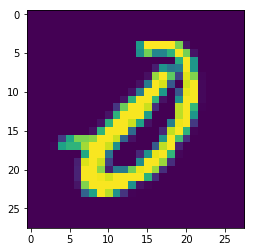

In [18]:
plt.imshow(data_discrepencies[100].reshape(28, 28), interpolation='nearest')